In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import datetime as dt
import pytz
import seaborn as sns
from datetime import datetime, timedelta
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix  
from matplotlib.lines import Line2D


In [3]:
def evaluate(y, ypred, threshold): 

    #classnames  = ['0 =< vis =< 1 miles', '1< vis =< 2 miles', '2 < vis =< 4 miles', '4 < vis < 6 miles','6 =< vis < 10 miles']
    # confusion Matrix: 
    length = len(ypred) 
    ypred_ = [0]*length 
    '''for i in range(length):
        ypred_[i] = numpy.argmax(ypred[i, :]) '''
    ypred_ = np.array(ypred_)   

    for i in range(length):
        prob = ypred[i, 1] 
        if prob > threshold:
            ypred_[i] = 1
        else:
            ypred_[i] = 0

    ypred_ = np.array(ypred_)
    tn, fp, fn, tp = confusion_matrix(y, ypred_).ravel()
    a = tn     # Hit
    #print('Hit: ', a,  file=open(save_name, "a"))
    b = fn      # false alarm
    #print('False alarm: ', b,  file=open(save_name, "a"))
    c = fp      # miss
    #print('Miss: ', c,  file=open(save_name, "a"))
    d = tp    # correct rejection 
    #print('Correct rejection: ', d,  file=open(save_name, "a"))
    AUC = roc_auc_score(y, ypred_) 
    #print('AUC  : ', AUC) 
    
    POD = a/(a+c)
    
    FAR  = b/(a+b)
    #print('FAR  : ', FAR)
    
    CSI = a/(a+b+c)
    #print('CSI  : ', CSI)
    
    HSS = (2*((a*d)-(b*c)))/(((a+c)*(c+d))+((a+b)*(b+d)))
    #print('HSS  : ', HSS) 
    #
    return [a, c, b, d] 

In [5]:
## Defult Dirc: 

test_target = "./results/"

### Monthly Evaluaitng 

In [6]:
_6hr = pd.read_csv(test_target+ '6hr/C38C0/TC38C0.csv')
_12hr = pd.read_csv(test_target+ '12hr/C1C0/VIS_Prob_TEST.csv')
_24hr = pd.read_csv(test_target+ '24hr/C41C0/VIS_Prob_TEST.csv')

In [7]:
gt = pd.read_csv(test_target + 'test.csv') 
cond_c0 = [(gt['VIS'] <= 1), (gt['VIS'] > 1)]
values_c0 = [0,1]
###
cond_c1 = [(gt['VIS'] <= 2), (gt['VIS'] > 2)]
values_c1 = [0,1]
#
cond_c2 = [(gt['VIS'] < 4), (gt['VIS'] >= 4)] 
values_c2 = [0,1]
#
gt['C0'] = np.select(cond_c0, values_c0)  
gt['C1'] = np.select(cond_c1, values_c1)  
gt['C2'] = np.select(cond_c2, values_c2)  

gt['date'] = pd.to_datetime(gt['date'], format='%Y%m%d') 
gt['index'] =  pd.to_datetime(gt['date']).dt.to_period('M')

gt['6hr_C0_Prob'] = _6hr['C0_Prob']
gt['6hr_C1_Prob'] = _6hr['C1_Prob'] 

gt['12hr_C0_Prob'] = _12hr['C0_Prob']
gt['12hr_C1_Prob'] = _12hr['C1_Prob'] 

gt['24hr_C0_Prob'] = _24hr['C0_Prob']
gt['24hr_C1_Prob'] = _24hr['C1_Prob'] 

In [44]:
gt.to_csv('./output.csv')

In [9]:
def eval_calc(gt, uniques, leadtime):
    results = np.empty([25, 5], dtype=float)
    
    for i in range(len(uniques)):
        monthdata = gt[gt['index'] == uniques[i]]
        fogcases = monthdata[monthdata.C0 == 0].shape[0]
        
        if fogcases == 0: 
            results [i, 0] = 0
            results [i, 1] = 0
            results [i, 2] = 0
            results [i, 3] = 0
            results [i, 4] = 0

            
        elif fogcases != 0: 
            if (leadtime == '6hr'):
                y = monthdata['C0'].to_numpy() 
                ypred = monthdata[['6hr_C0_Prob', '6hr_C1_Prob']].to_numpy()
                r = np.array(evaluate(y, ypred, 0.58))
                r[np.isnan(r)] = 0
                results [i, 0] = r[0]
                results [i, 1] = r[1]
                results [i, 2] = r[2]
                results [i, 3] = r[3]
                results [i, 4] = fogcases

            elif leadtime == '12hr':
                y = monthdata['C0'].to_numpy() 
                ypred = monthdata[['12hr_C0_Prob', '12hr_C1_Prob']].to_numpy()
                r = np.array(evaluate(y, ypred, 0.54)) 
                r[np.isnan(r)] = 0
                results [i, 0] = r[0]
                results [i, 1] = r[1]
                results [i, 2] = r[2]
                results [i, 3] = r[3]
                results [i, 4] = fogcases


            elif leadtime == '24hr':
                y = monthdata['C0'].to_numpy() 
                ypred = monthdata[['24hr_C0_Prob', '24hr_C1_Prob']].to_numpy()
                r = np.array(evaluate(y, ypred, 0.48))
                r[np.isnan(r)] = 0
                results [i, 0] = r[0]
                results [i, 1] = r[1]
                results [i, 2] = r[2]
                results [i, 3] = r[3]
                results [i, 4] = fogcases
               
                
    return results 

In [10]:
uniques = gt['index'].unique()
results = eval_calc(gt, uniques, '6hr')

<ipython-input-4-27fdcf39c5a3>:33: RuntimeWarning: invalid value encountered in longlong_scalars
  FAR  = b/(a+b)


In [11]:
results

array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,  43.,   1.],
       [  1.,   2.,   7.,  82.,   3.],
       [  0.,   2.,   2., 108.,   2.],
       [  0.,   0.,   0.,   0.,   0.],
       [ 16.,   4.,  12.,  60.,  20.],
       [ 11.,   0.,   3.,  90.,  11.],
       [  3.,   0.,   4.,  89.,   3.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   3.,  84.,   1.],
       [  1.,   1.,   0., 110.,   2.],
       [  6.,   6.,   1.,  95.,  12.],
       [  0.,   1.,   3., 108.,   1.],
       [  2.,   2.,   6.,  90.,   4.],
       [  5.,   2.,   2.,  91.,   7.],
       [  0.,   0.,   0.,   0.,   0.]])

In [12]:
plotdata = gt['date'].groupby([gt.date.dt.year, gt.date.dt.month]).agg('count')
datecount = pd.DataFrame()
dates = ["2018-05-01", "2020-05-31"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array = OrderedDict(((start + timedelta(_)).strftime(r"%b-%y"), None) for _ in range((end - start).days))
#array = np.array([*array]) 

datecount['datetime'] = array 
datecount['count']    = np.array([8, 76, 84, 92, 40, 44, 92, 112, 100, 92, 104, 96, 80, 68, 116, 120,84, 120, 88, 112, 108, 112, 100, 100, 80])
datecount['FogCases'] = results[:, 4]
datecount['Hit']      = results[:, 0]
datecount['Miss']     = results[:, 1]
datecount['FA']       = results[:, 2]
datecount['CR']       = results[:, 3]

In [13]:
datecount

,datetime,count,FogCases,Hit,Miss,FA,CR
May-18,May-18,8,0.0,0.0,0.0,0.0,0.0
Jun-18,Jun-18,76,0.0,0.0,0.0,0.0,0.0
Jul-18,Jul-18,84,0.0,0.0,0.0,0.0,0.0
Aug-18,Aug-18,92,0.0,0.0,0.0,0.0,0.0
Sep-18,Sep-18,40,0.0,0.0,0.0,0.0,0.0
Oct-18,Oct-18,44,1.0,0.0,1.0,0.0,43.0
Nov-18,Nov-18,92,3.0,1.0,2.0,7.0,82.0
Dec-18,Dec-18,112,2.0,0.0,2.0,2.0,108.0
Jan-19,Jan-19,100,0.0,0.0,0.0,0.0,0.0
Feb-19,Feb-19,92,20.0,16.0,4.0,12.0,60.0


In [14]:
dates = ["2020-01-01", "2020-12-31"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array = OrderedDict(((start + timedelta(_)).strftime(r"%b"), None) for _ in range((end - start).days))
array = np.array([*array]) 

count    = [208, 204, 204, 196, 188, 144, 200, 212, 124, 164, 180, 224]
fogcases = [12,  21,  15,  10,   0,   0,   0,   0,   0,   1,   4,   4]
Hit      = [6,   16,  13,  8,    0,   0,   0,   0,   0,   0,   1,   1]
Miss     = [6,   5,   2,   2,    0,   0,   0,   0,   0,   1,   3,   3]
FA       = [1,   15,  9,   6,    0,   0,   0,   0,   0,   0,   10,  2]
CR       = [95, 168, 180, 180,  188,  144, 200, 212, 124,163, 166, 218] 


NewData = pd.DataFrame() 

NewData['index']    = array
NewData['count']    = count
NewData['fogcases'] = fogcases
NewData['Hit']      = Hit
NewData['Miss']     = Miss
NewData['FA']       = FA
NewData['CR']       = CR

NewData

,index,count,fogcases,Hit,Miss,FA,CR
0,Jan,208,12,6,6,1,95
1,Feb,204,21,16,5,15,168
2,Mar,204,15,13,2,9,180
3,Apr,196,10,8,2,6,180
4,May,188,0,0,0,0,188
5,Jun,144,0,0,0,0,144
6,Jul,200,0,0,0,0,200
7,Aug,212,0,0,0,0,212
8,Sep,124,0,0,0,0,124
9,Oct,164,1,0,1,0,163


No handles with labels found to put in legend.
No handles with labels found to put in legend.


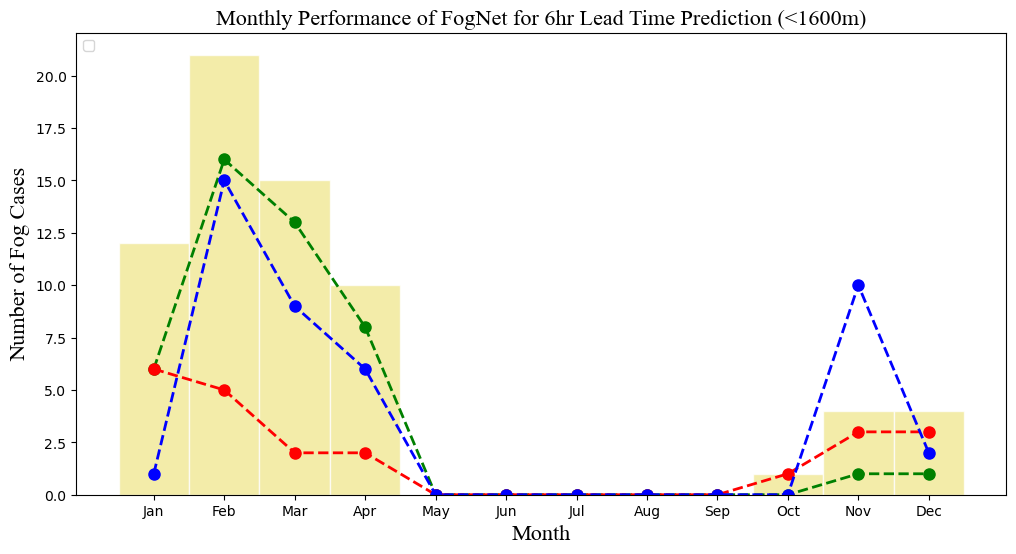

In [15]:
fig, ax1 = plt.subplots(figsize=(12,6)) 
## Bar chart
ax1.set_title('Monthly Performance of FogNet for 6hr Lead Time Prediction (<1600m)', fontname = 'Times New Roman', fontsize = 16)
ax1.set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
ax1.set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)


bars1 = NewData['count']
bars2 = NewData['fogcases']


# Names of group and bar width
names = NewData['index']
barWidth = 1

ax1.bar(names, bars2, color='khaki', edgecolor='white', width=barWidth, alpha=0.75)
ax1.tick_params(axis='y') 


hit = NewData['Hit']
miss = NewData['Miss']
fa = NewData['FA']
ax1.plot(names, hit, 'go--', linewidth=2, markersize=8)
ax1.plot(names, miss, 'ro--', linewidth=2, markersize=8)
ax1.plot(names, fa, 'bo--', linewidth=2, markersize=8)
#ax1.legend(loc='upper left') 
leg = ax1.legend();


plt.legend(loc="upper left")
#plt.setp(ax1.xaxis.get_majorticklabels(), fontname = 'Times New Roman', fontsize=16)

plt.show()

#### Plot1

In [16]:
dates = ["2020-07-01", "2021-06-30"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array = OrderedDict(((start + timedelta(_)).strftime(r"%b"), None) for _ in range((end - start).days))
array = np.array([*array]) 

count    = [200, 212, 124, 164, 180, 224, 208, 204, 204, 196, 188, 144]
fogcases = [ 0,   0,   0,   1,   4,   4, 12,  21,  15,  10,   0,   0]
Hit      = [ 0,   0,   0,   0,   1,   1, 6,   16,  13,  8,    0,   0]
Miss     = [ 0,   0,   0,   1,   3,   3, 6,   5,   2,   2,    0,   0]
FA       = [ 0,   0,   0,   0,   10,  2, 1,   15,  9,   6,    0,   0]
CR       = [200, 212, 124,163, 166, 218, 95, 168, 180, 180,  188,  144] 


NewData2 = pd.DataFrame() 

NewData2['Month']    = array
NewData2['All Cases']    = count
NewData2['Fog Cases'] = fogcases
NewData2['Hit']      = Hit
NewData2['Miss']     = Miss
NewData2['FA']       = FA
NewData2['CR']       = CR

NewData2

,Month,All Cases,Fog Cases,Hit,Miss,FA,CR
0,Jul,200,0,0,0,0,200
1,Aug,212,0,0,0,0,212
2,Sep,124,0,0,0,0,124
3,Oct,164,1,0,1,0,163
4,Nov,180,4,1,3,10,166
5,Dec,224,4,1,3,2,218
6,Jan,208,12,6,6,1,95
7,Feb,204,21,16,5,15,168
8,Mar,204,15,13,2,9,180
9,Apr,196,10,8,2,6,180


#### 12 Hrs

In [17]:
uniques = gt['index'].unique()
results12 = eval_calc(gt, uniques, '12hr')
results12

array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   1.,  42.,   1.],
       [  0.,   3.,   7.,  82.,   3.],
       [  0.,   2.,   1., 109.,   2.],
       [  0.,   0.,   0.,   0.,   0.],
       [ 16.,   4.,  14.,  58.,  20.],
       [  9.,   2.,   4.,  89.,  11.],
       [  3.,   0.,   1.,  92.,   3.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   4.,  83.,   1.],
       [  1.,   1.,   0., 110.,   2.],
       [  5.,   7.,   2.,  94.,  12.],
       [  1.,   0.,   6., 105.,   1.],
       [  1.,   3.,   5.,  91.,   4.],
       [  5.,   2.,   1.,  92.,   7.],
       [  0.,   0.,   0.,   0.,   0.]])

In [18]:
plotdata12 = gt['date'].groupby([gt.date.dt.year, gt.date.dt.month]).agg('count')
datecount12 = pd.DataFrame()
dates = ["2018-05-01", "2020-05-31"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array12 = OrderedDict(((start + timedelta(_)).strftime(r"%b-%y"), None) for _ in range((end - start).days))
#array = np.array([*array]) 

datecount12['datetime'] = array12 
datecount12['count']    = np.array([8, 76, 84, 92, 40, 44, 92, 112, 100, 92, 104, 96, 80, 68, 116, 120,84, 120, 88, 112, 108, 112, 100, 100, 80])
datecount12['FogCases'] = results12[:, 4]
datecount12['Hit']      = results12[:, 0]
datecount12['Miss']     = results12[:, 1]
datecount12['FA']       = results12[:, 2]
datecount12['CR']       = results12[:, 3]

In [12]:
datecount12

,datetime,count,FogCases,Hit,Miss,FA,CR
May-18,May-18,8,0.0,0.0,0.0,0.0,0.0
Jun-18,Jun-18,76,0.0,0.0,0.0,0.0,0.0
Jul-18,Jul-18,84,0.0,0.0,0.0,0.0,0.0
Aug-18,Aug-18,92,0.0,0.0,0.0,0.0,0.0
Sep-18,Sep-18,40,0.0,0.0,0.0,0.0,0.0
Oct-18,Oct-18,44,1.0,0.0,1.0,1.0,42.0
Nov-18,Nov-18,92,3.0,0.0,3.0,7.0,82.0
Dec-18,Dec-18,112,2.0,0.0,2.0,1.0,109.0
Jan-19,Jan-19,100,0.0,0.0,0.0,0.0,0.0
Feb-19,Feb-19,92,20.0,16.0,4.0,14.0,58.0


In [19]:
dates = ["2020-07-01", "2021-06-30"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array = OrderedDict(((start + timedelta(_)).strftime(r"%b"), None) for _ in range((end - start).days))
array = np.array([*array]) 

count    = [200, 212, 124, 164, 180, 224, 208, 204, 204, 196, 188, 144]
fogcases = [ 0,   0,   0,   1,   4,   4, 12,  21,  15,  10,   0,   0]
Hit12      = [ 0,   0,   0,   0,   0,   1, 5,   17,  10,  8,    0,   0]
Miss12     = [ 0,   0,   0,   1,   4,   3, 7,   4,   5,   2,    0,   0]
FA12       = [ 0,   0,   0,   1,   11,  1, 2,   20,  9,   2,    0,   0]
CR12       = [200, 212, 124,162, 165, 219, 94, 163, 180, 184,  188,  144] 


NewData12 = pd.DataFrame() 

NewData12['Month']    = array
NewData12['All Cases']    = count
NewData12['Fog Cases'] = fogcases
NewData12['Hit']      = Hit12
NewData12['Miss']     = Miss12
NewData12['FA']       = FA12
NewData12['CR']       = CR12

NewData12

,Month,All Cases,Fog Cases,Hit,Miss,FA,CR
0,Jul,200,0,0,0,0,200
1,Aug,212,0,0,0,0,212
2,Sep,124,0,0,0,0,124
3,Oct,164,1,0,1,1,162
4,Nov,180,4,0,4,11,165
5,Dec,224,4,1,3,1,219
6,Jan,208,12,5,7,2,94
7,Feb,204,21,17,4,20,163
8,Mar,204,15,10,5,9,180
9,Apr,196,10,8,2,2,184


#### 24 hr

In [20]:
uniques = gt['index'].unique()
results24 = eval_calc(gt, uniques, '24hr')
results24

<ipython-input-4-27fdcf39c5a3>:33: RuntimeWarning: invalid value encountered in longlong_scalars
  FAR  = b/(a+b)


array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,  43.,   1.],
       [  1.,   2.,   2.,  87.,   3.],
       [  1.,   1.,   3., 107.,   2.],
       [  0.,   0.,   0.,   0.,   0.],
       [ 17.,   3.,  10.,  62.,  20.],
       [  9.,   2.,   4.,  89.,  11.],
       [  3.,   0.,   2.,  91.,   3.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   2.,  85.,   1.],
       [  0.,   2.,   3., 107.,   2.],
       [  2.,  10.,   0.,  96.,  12.],
       [  0.,   1.,   3., 108.,   1.],
       [  1.,   3.,   3.,  93.,   4.],
       [  2.,   5.,   2.,  91.,   7.],
       [  0.,   0.,   0.,   0.,   0.]])

In [21]:
plotdata24 = gt['date'].groupby([gt.date.dt.year, gt.date.dt.month]).agg('count')
datecount24 = pd.DataFrame()
dates = ["2018-05-01", "2020-05-31"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array24 = OrderedDict(((start + timedelta(_)).strftime(r"%b-%y"), None) for _ in range((end - start).days))
#array = np.array([*array]) 

datecount24['datetime'] = array24 
datecount24['count']    = np.array([8, 76, 84, 92, 40, 44, 92, 112, 100, 92, 104, 96, 80, 68, 116, 120,84, 120, 88, 112, 108, 112, 100, 100, 80])
datecount24['FogCases'] = results24[:, 4]
datecount24['Hit']      = results24[:, 0]
datecount24['Miss']     = results24[:, 1]
datecount24['FA']       = results24[:, 2]

In [22]:
datecount24

,datetime,count,FogCases,Hit,Miss,FA
May-18,May-18,8,0.0,0.0,0.0,0.0
Jun-18,Jun-18,76,0.0,0.0,0.0,0.0
Jul-18,Jul-18,84,0.0,0.0,0.0,0.0
Aug-18,Aug-18,92,0.0,0.0,0.0,0.0
Sep-18,Sep-18,40,0.0,0.0,0.0,0.0
Oct-18,Oct-18,44,1.0,0.0,1.0,0.0
Nov-18,Nov-18,92,3.0,1.0,2.0,2.0
Dec-18,Dec-18,112,2.0,1.0,1.0,3.0
Jan-19,Jan-19,100,0.0,0.0,0.0,0.0
Feb-19,Feb-19,92,20.0,17.0,3.0,10.0


In [23]:
dates = ["2020-07-01", "2021-06-30"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
array = OrderedDict(((start + timedelta(_)).strftime(r"%b"), None) for _ in range((end - start).days))
array = np.array([*array]) 

count      = [200, 212, 124, 164, 180, 224, 208, 204, 204, 196, 188, 144]
fogcases   = [ 0,   0,   0,   1,   4,   4, 12,  21,  15,  10,   0,   0]
Hit24      = [ 0,   0,   0,   0,   1,   1, 2,   17,  10,  5,    0,   0]
Miss24     = [ 0,   0,   0,   1,   3,   3, 10,  4,   5,   5,    0,   0]
FA24       = [ 0,   0,   0,   1,   11,  6, 3,   13,  7,   4,    0,   0]
CR24       = [200, 212, 124,162, 165, 214, 93, 170, 182, 182,  188,  144] 


NewData24 = pd.DataFrame() 

NewData24['Month']    = array
NewData24['All Cases']    = count
NewData24['Fog Cases'] = fogcases
NewData24['Hit']      = Hit24
NewData24['Miss']     = Miss24
NewData24['FA']       = FA24
NewData24['CR']       = CR24

NewData24

,Month,All Cases,Fog Cases,Hit,Miss,FA,CR
0,Jul,200,0,0,0,0,200
1,Aug,212,0,0,0,0,212
2,Sep,124,0,0,0,0,124
3,Oct,164,1,0,1,1,162
4,Nov,180,4,1,3,11,165
5,Dec,224,4,1,3,6,214
6,Jan,208,12,2,10,3,93
7,Feb,204,21,17,4,13,170
8,Mar,204,15,10,5,7,182
9,Apr,196,10,5,5,4,182


In [29]:
cfog = pd.DataFrame()

Alldates = ["2020-07-01", "2021-06-30"]
start1, end1 = [datetime.strptime(_, "%Y-%m-%d") for _ in Alldates]
arrayAll = OrderedDict(((start1 + timedelta(_)).strftime(r"%b"), None) for _ in range((end1 - start1).days))
arrayAll = np.array([*arrayAll]) 

dates2 = ["2020-10-01", "2021-04-30"]
start2, end2 = [datetime.strptime(_, "%Y-%m-%d") for _ in dates2]
array2 = OrderedDict(((start2 + timedelta(_)).strftime(r"%b"), None) for _ in range((end2 - start2).days))
array2 = np.array([*array2]) 





count      = [200, 212, 124, 164, 180, 224, 208, 204, 204, 196, 188, 144]
fogcases   = [ 0,   0,   0,   1,   4,   4, 12,  21,  15,  10,   0,   0]
fogcases2   = [ 1,   4,   4, 12,  21,  15,  10]


cfog ['Month']     = arrayAll
cfog ['All Cases'] =  count
cfog ['Fog Cases'] =  fogcases


Hit6       = [ 0,   1,   1,   6,   16,  13,  8]
Miss6      = [ 1,   3,   3,   6,   5,   2,   2]
FA6        = [ 0,  10,   2,   1,   15,  9,   6]

Hit12      = [ 0,   0,   1,   5,   17,  10,  8]
Miss12     = [ 1,   4,   3,   7,   4,   5,   2]
FA12       = [ 1,   11,  1,   2,   20,  9,   2]


Hit24      = [ 0,   1,   1,   2,   17,  10,  5]
Miss24     = [ 1,   3,   3,   10,  4,   5,   5]
FA24       = [ 1,   11,  6,   3,   13,  7,   4]


AllData = pd.DataFrame()

AllData['Month']   = array2
AllData['Fog Cases']   = fogcases2
AllData['Hit6']   = Hit6
AllData['Miss6']  = Miss6
AllData['FA6']    = FA6
AllData['Hit12']  = Hit12
AllData['Miss12'] = Miss12
AllData['FA12']   = FA12
AllData['Hit24']  = Hit24
AllData['Miss24'] = Miss24
AllData['FA24']   =  FA24


AllData

,Month,Fog Cases,Hit6,Miss6,FA6,Hit12,Miss12,FA12,Hit24,Miss24,FA24
0,Oct,1,0,1,0,0,1,1,0,1,1
1,Nov,4,1,3,10,0,4,11,1,3,11
2,Dec,4,1,3,2,1,3,1,1,3,6
3,Jan,12,6,6,1,5,7,2,2,10,3
4,Feb,21,16,5,15,17,4,20,17,4,13
5,Mar,15,13,2,9,10,5,9,10,5,7
6,Apr,10,8,2,6,8,2,2,5,5,4


### Plot with DF

In [24]:
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)



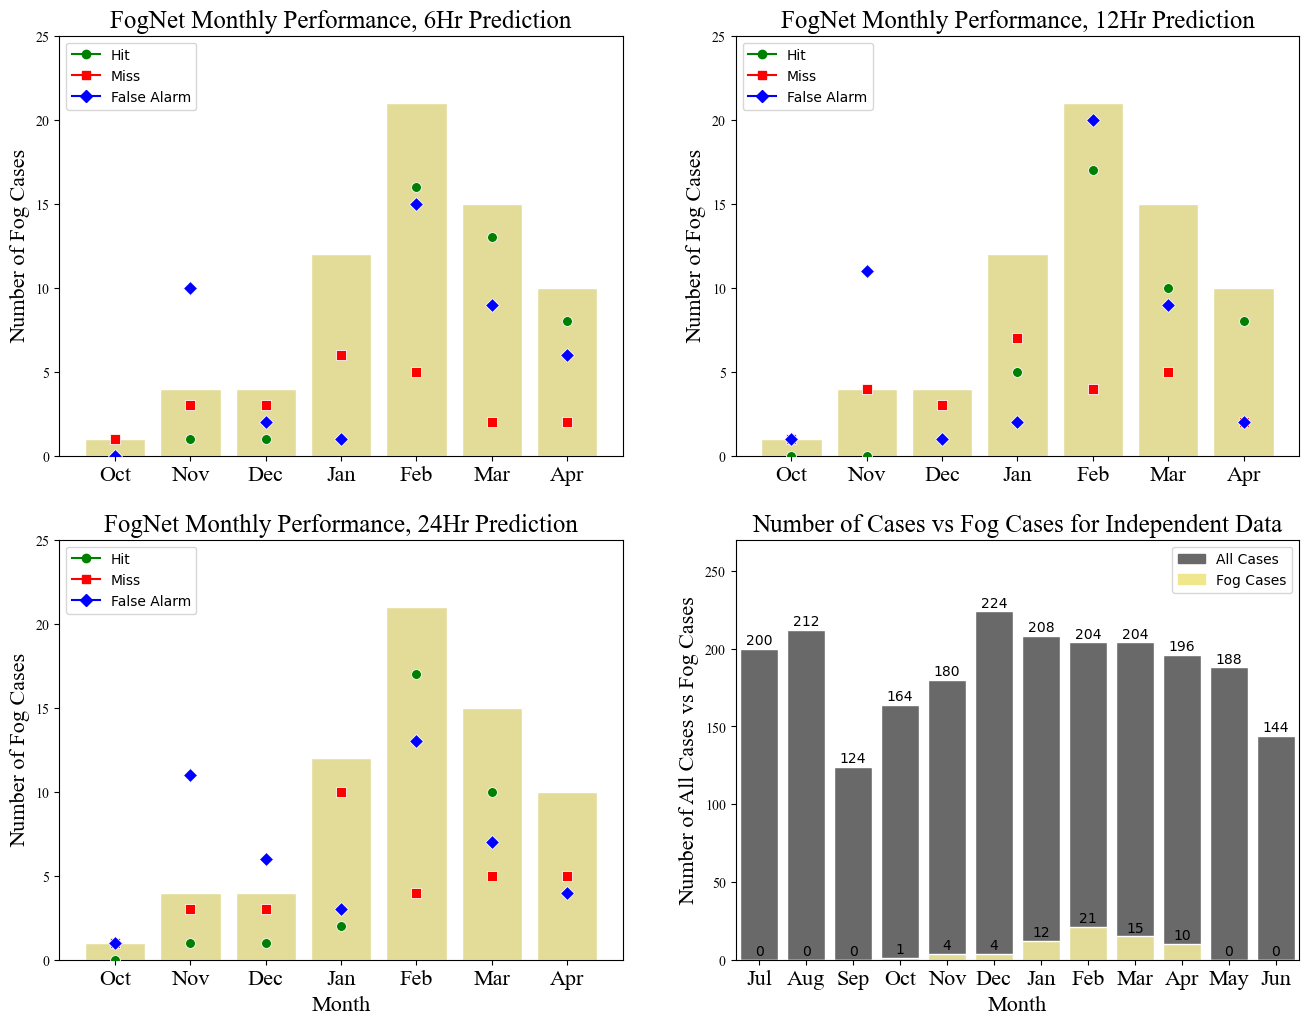

In [42]:
matplotlib.rc_file_defaults()
#ax1 = sns.set_style(style=None, rc=None )


fig, axs = plt.subplots(2, 2, figsize=(16,12))

#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0.1, wspace = 0.1)
#plt.margins(0,0)

legend_elements = [Line2D([0], [0], marker='o', color='g', label='Hit',
                         markerfacecolor='g'),
                   Line2D([0], [0], marker='s', color='r', label='Miss',
                          markerfacecolor='r'),
                   Line2D([0], [0], marker='D', color='b', label='False Alarm',
                          markerfacecolor='b')
]

NA = patches.Patch(color='dimgray', label='All Cases')
EU = patches.Patch(color='Khaki', label='Fog Cases')


##########Plot 1 6hr 
g = sns.barplot(data = AllData,  x='Month', y='Fog Cases', color='Khaki', edgecolor='white', ax=axs[0, 0])
g.set(ylim=(0, 25))
g.set(xlabel = None)

H6 = sns.scatterplot(data = AllData, x='Month', y='Hit6',  marker='o', s = 50, 
                     color='green', alpha=1, ax=axs[0, 0], zorder=10)
H6.set(xlabel = None)
M6 = sns.scatterplot(data = AllData, x='Month', y='Miss6', marker='s', s = 50, 
                     color='red',   alpha=1, ax=axs[0, 0], zorder=10)
M6.set(xlabel = None)
F6 = sns.scatterplot(data = AllData, x='Month', y='FA6',   marker='D', s = 50, 
                     color='blue',  alpha=1, ax=axs[0, 0], zorder=10)
F6.set(xlabel = None)


##########Plot 2 12hr 
g = sns.barplot(data = AllData,  x='Month', y='Fog Cases', color='Khaki', edgecolor='white', ax=axs[0, 1])
g.set(ylim=(0, 25))
H12 = sns.scatterplot(data = AllData, x='Month', y='Hit12',  marker='o', s = 50,  
                      color='green', alpha=1, ax=axs[0, 1], zorder=10)
M12 = sns.scatterplot(data = AllData, x='Month', y='Miss12', marker='s', s = 50, 
                      color='red',   alpha=1, ax=axs[0, 1], zorder=10)
F12 = sns.scatterplot(data = AllData, x='Month', y='FA12',   marker='D',  s = 50,
                      color='blue',  alpha=1, ax=axs[0, 1], zorder=10)

##########Plot 3 24hr 
g = sns.barplot(data = AllData,  x='Month', y='Fog Cases', color='Khaki', edgecolor='white', ax=axs[1, 0])
g.set(ylim=(0, 25))

H24 = sns.scatterplot(data = AllData, x='Month', y='Hit24',  marker='o', s = 50, 
                      color='green', alpha=1, ax=axs[1, 0], zorder=20)
M24 = sns.scatterplot(data = AllData, x='Month', y='Miss24', marker='s', s = 50, 
                      color='red',   alpha=1, ax=axs[1, 0], zorder=20)
F24 = sns.scatterplot(data = AllData, x='Month', y='FA24',   marker='D', s= 50,  
                      color='blue',  alpha=1, ax=axs[1, 0], zorder=20)

##########Plot 4 cases 
g1 = sns.barplot(data = NewData2,  x='Month', y='All Cases', color='dimgray', edgecolor='white', ax=axs[1, 1])
#g.set(ylim=(0, 25))
g2 = sns.barplot(data = NewData2,  x='Month', y='Fog Cases', color='Khaki', edgecolor='white', ax=axs[1, 1])

g1.set(ylim=(0, 270))
# Iterrating over the bars one-by-one 
for bar in g1.patches: 
    
  # Using Matplotlib's annotate function and 
  # passing the coordinates where the annotation shall be done 
  # x-coordinate: bar.get_x() + bar.get_width() / 2 
  # y-coordinate: bar.get_height() 
  # free space to be left to make graph pleasing: (0, 8) 
  # ha and va stand for the horizontal and vertical alignment 
    g1.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=10, xytext=(0, 6), 
                   textcoords='offset points') 


axs[0, 0].set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
axs[0, 0].set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)

axs[0, 1].set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
axs[0, 1].set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)

axs[1, 0].set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
axs[1, 0].set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)

axs[1, 1].set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
axs[1, 1].set_ylabel('Number of All Cases vs Fog Cases', fontname = 'Times New Roman', fontsize=16)


plt.setp(axs[0, 0].xaxis.get_majorticklabels(), fontname = 'Times New Roman', fontsize=16)
axs[0, 0].set_xlabel('')
plt.setp(axs[0, 0].yaxis.get_majorticklabels(), fontname = 'Times New Roman')

axs[0, 1].set_xlabel('')
plt.setp(axs[0, 1].xaxis.get_majorticklabels(), fontname = 'Times New Roman', fontsize=16)
plt.setp(axs[0, 1].yaxis.get_majorticklabels(), fontname = 'Times New Roman')

plt.setp(axs[1, 0].xaxis.get_majorticklabels(), fontname = 'Times New Roman', fontsize=16)
plt.setp(axs[1, 0].yaxis.get_majorticklabels(), fontname = 'Times New Roman')

plt.setp(axs[1, 1].xaxis.get_majorticklabels(), fontname = 'Times New Roman', fontsize=16)
plt.setp(axs[1, 1].yaxis.get_majorticklabels(), fontname = 'Times New Roman')

axs[0, 0].legend(handles=legend_elements, loc = 'upper left')
axs[0, 1].legend(handles=legend_elements, loc = 'upper left')
axs[1, 0].legend(handles=legend_elements, loc = 'upper left')

axs[1, 1].legend(handles=[NA,EU], loc='upper right')


axs[0, 0].set_title('FogNet Monthly Performance, 6Hr Prediction', fontname = 'Times New Roman', fontsize=18)
axs[0, 1].set_title('FogNet Monthly Performance, 12Hr Prediction', fontname = 'Times New Roman', fontsize=18)
axs[1, 0].set_title('FogNet Monthly Performance, 24Hr Prediction', fontname = 'Times New Roman', fontsize=18)
axs[1, 1].set_title('Number of Cases vs Fog Cases for Independent Data', fontname = 'Times New Roman', fontsize=18)

filename = 'output2.png'
plt.savefig(filename, dpi = 300) 

In [24]:
fogtype = pd.DataFrame()

names      = ['Combination', 'Advection', 'Others']
cases      = [68, 55, 13]
Hit24      = [ 41, 37, 4]
Miss24     = [ 27, 18, 9]

fogtype['Fog Types'] = names
fogtype['Cases'] = cases
fogtype['Hit']   = Hit24
fogtype['Miss']   = Miss24 

fogtype

,Fog Types,Cases,Hit,Miss
0,Combination,68,41,27
1,Advection,55,37,18
2,Others,13,4,9


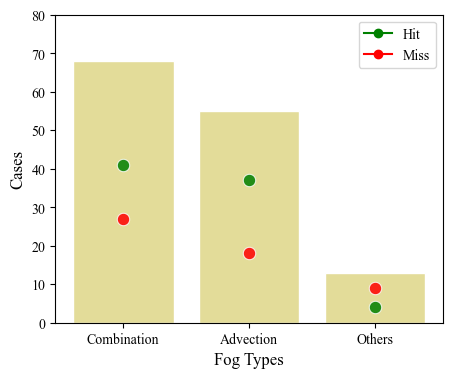

<Figure size 640x480 with 0 Axes>

In [25]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )


fig, ax1 = plt.subplots(figsize=(5,4))
ax1.set_xlabel('Fog Type Performance of FogNet', fontname = 'Times New Roman', fontsize=12)
ax1.set_ylabel('Number of Cases', fontname = 'Times New Roman', fontsize=12)



legend_elements = [Line2D([0], [0], marker='o', color='g', label='Hit',
                         markerfacecolor='g'),
                   Line2D([0], [0], marker='o', color='r', label='Miss',
                          markerfacecolor='r')
]


g = sns.barplot(data = fogtype,  x='Fog Types', y='Cases', color='Khaki', edgecolor='white', ax=ax1)
g.set(ylim=(0, 80))

H = sns.scatterplot(data = fogtype, x='Fog Types', y='Hit',  marker='o', color='green', alpha=0.85, ax=ax1, zorder=20, s=80)
M = sns.scatterplot(data = fogtype, x='Fog Types', y='Miss', marker='o', color='red',   alpha=0.85, ax=ax1, zorder=20, s=80)

plt.rcParams['font.size'] = 10
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']


#plt.legend(labels=['Hit', 'Miss', 'False Alarm'], loc = 'upper left')
plt.legend(handles=legend_elements, loc = 'upper right')
plt.setp(ax1.xaxis.get_majorticklabels(), fontname = 'Times New Roman')
plt.setp(ax1.yaxis.get_majorticklabels(), fontname = 'Times New Roman')

plt.show()
plt.savefig('destination_path.eps', format='eps') 

# Old Version plots 

No handles with labels found to put in legend.


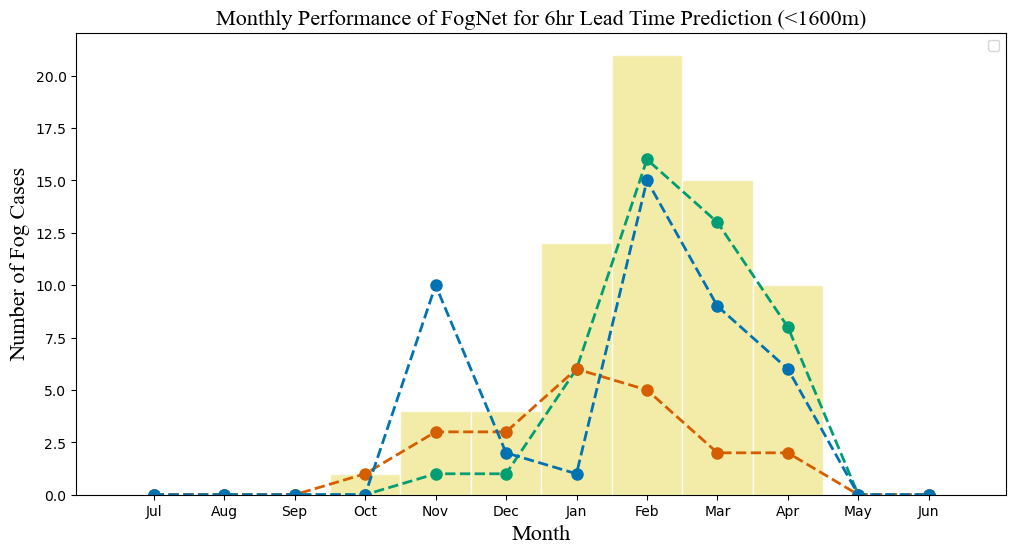

In [136]:
matplotlib.rc_file_defaults()

fig, ax1 = plt.subplots(1, figsize=(12,6)) 
## Bar chart
ax1.set_title('Monthly Performance of FogNet for 6hr Lead Time Prediction (<1600m)', fontname = 'Times New Roman', fontsize = 16)
ax1.set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
ax1.set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)


bars1 = NewData2['count']
bars2 = NewData2['fogcases']


# Names of group and bar width
names = NewData2['index']
barWidth = 1

ax1.bar(names, bars2, color='khaki', edgecolor='white', width=barWidth, alpha=0.75)
ax1.tick_params(axis='y') 


#ax2=ax1.twinx()

hit = NewData['Hit']
miss = NewData['Miss']
fa = NewData['FA']
ax1.plot(names, hit, 'go--', linewidth=2, markersize=8)
ax1.plot(names, miss, 'ro--', linewidth=2, markersize=8)
ax1.plot(names, fa, 'bo--', linewidth=2, markersize=8)
ax1.legend();


#plt.legend(loc="upper left")
plt.grid(False)
plt.show()

In [190]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )


fig, (ax1, ax2) = plt.subplots((2,1), mfigsize=(5,4))
ax1.set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
ax1.set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)

sns.lineplot(data = hit, marker='o', color='green', alpha=0.5, sort = False, ax=ax1)
sns.lineplot(data = miss, marker='o', color='red', alpha=0.5, sort = False, ax=ax1)
sns.lineplot(data = fa, marker='o', color='blue',  alpha=0.5, sort = False, ax=ax1)

g = sns.barplot(data = NewData2,  x='Month', y='Fog Cases', color='Khaki', edgecolor='white', alpha=0.75, ax=ax1)
g.set(ylim=(0, 25))
plt.legend(labels=['Hit', 'Miss', 'False Alarm'], loc = 'upper left')



plt.show()

TypeError: __init__() got an unexpected keyword argument 'mfigsize'

No handles with labels found to put in legend.
No handles with labels found to put in legend.


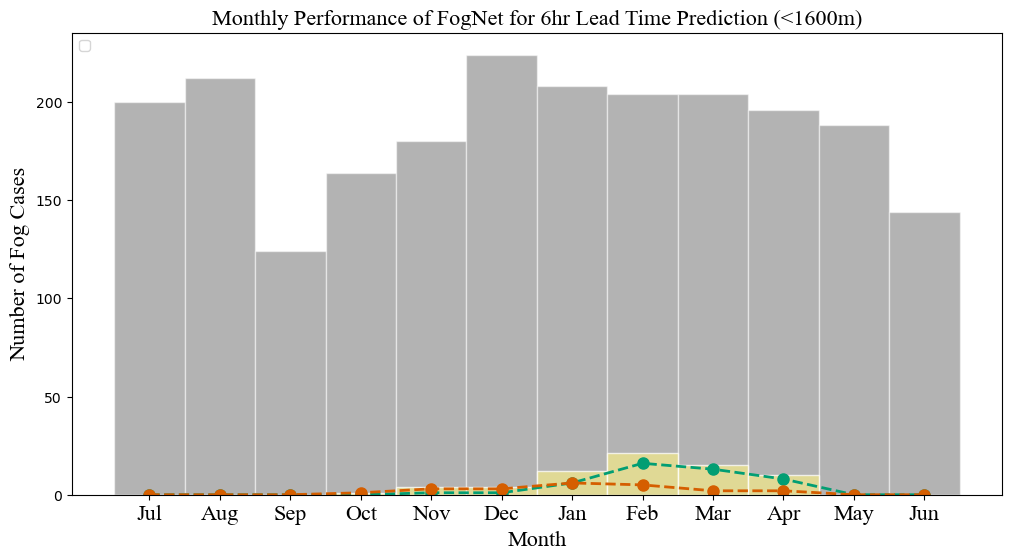

In [124]:
matplotlib.rc_file_defaults()

fig, ax1 = plt.subplots(figsize=(12,6)) 
## Bar chart
ax1.set_title('Monthly Performance of FogNet for 6hr Lead Time Prediction (<1600m)', fontname = 'Times New Roman', fontsize = 16)
ax1.set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
ax1.set_ylabel('Number of Fog Cases', fontname = 'Times New Roman', fontsize=16)


bars1 = NewData['count']
bars2 = NewData['fogcases']


# Names of group and bar width
names = NewData['index']
barWidth = 1
# Create brown bars
ax1.bar(names, bars1, color='dimgray', edgecolor='white', width=barWidth, alpha=0.5)
ax1.bar(names, bars2, color='khaki', edgecolor='white', width=barWidth, alpha=0.75)
#ax1.tick_params(axis='y') 


hit = NewData['Hit']
miss = NewData['Miss']
ax1.plot(names, hit, 'go--', linewidth=2, markersize=8)
ax1.plot(names, miss, 'ro--', linewidth=2, markersize=8)
#ax1.legend(loc='upper left') 
leg = ax1.legend();
#ax2.set_ylabel('Accuracy', fontname = 'Times New Roman', fontsize=16)

plt.legend(loc="upper left")
plt.setp(ax1.xaxis.get_majorticklabels(), fontname = 'Times New Roman', fontsize=16)
#plt.legend()
plt.show()

No handles with labels found to put in legend.


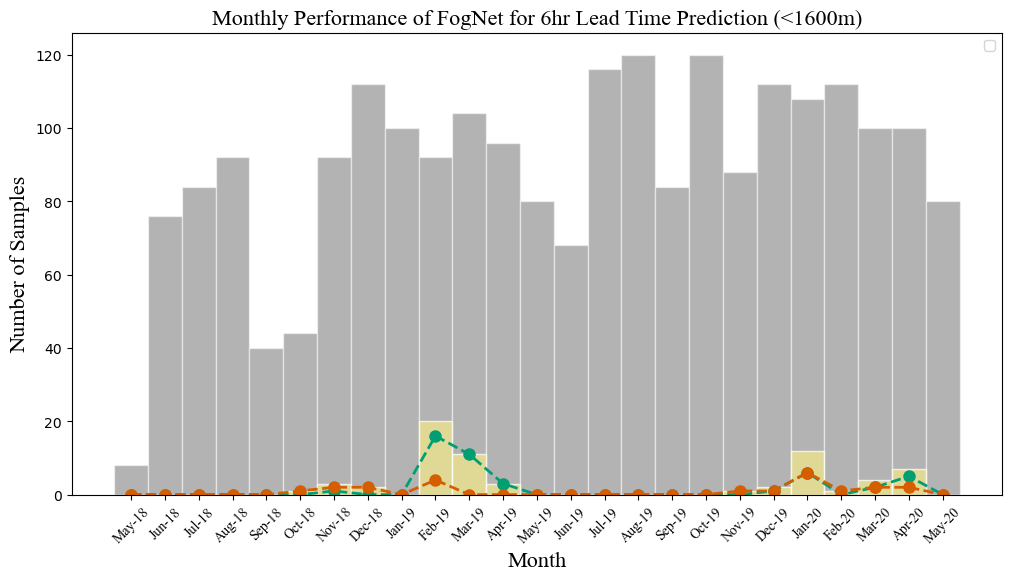

In [125]:
matplotlib.rc_file_defaults()

fig, ax1 = plt.subplots(figsize=(12,6)) 
## Bar chart
ax1.set_title('Monthly Performance of FogNet for 6hr Lead Time Prediction (<1600m)', fontname = 'Times New Roman', fontsize = 16)
ax1.set_xlabel('Month', fontname = 'Times New Roman', fontsize=16)
ax1.set_ylabel('Number of Samples', fontname = 'Times New Roman', fontsize=16)


bars1 = datecount['count']
bars2 = datecount['FogCases']
bars3 = [25, 3, 23, 25, 17]
 
# The position of the bars on the x-axis
r = np.arange(25)
# Names of group and bar width
names = datecount['datetime']
barWidth = 1
# Create brown bars
ax1.bar(names, bars1, color='dimgray', edgecolor='white', width=barWidth, alpha=0.5)
ax1.bar(names, bars2,  color='khaki', edgecolor='white', width=barWidth, alpha=0.75)
ax1.tick_params(axis='y') 

hit = datecount['Hit']
miss = datecount['Miss']
ax1.plot(names, hit, 'go--', linewidth=2, markersize=8)
ax1.plot(names, miss, 'ro--', linewidth=2, markersize=8)

plt.setp(ax1.xaxis.get_majorticklabels(), fontname = 'Times New Roman', rotation=45)
plt.legend()
plt.show()

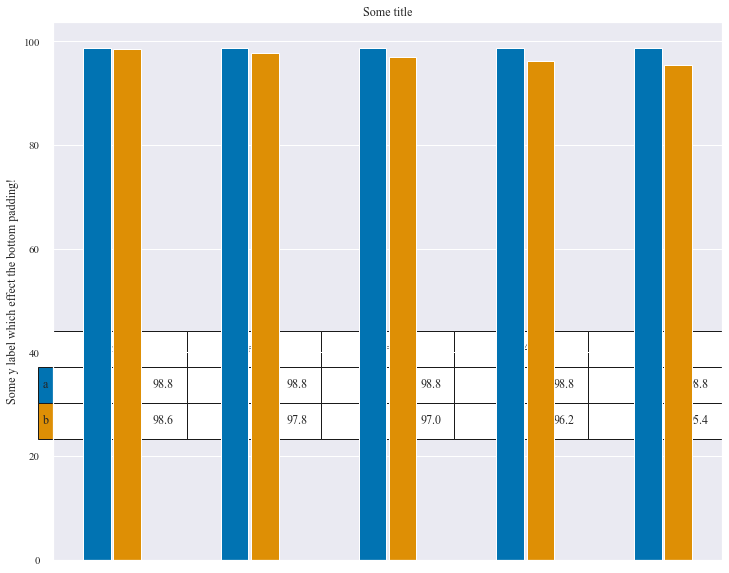

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# Set styles
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.style.use(['seaborn'])
sns.set(palette='colorblind')
matplotlib.rc("font", family="Times New Roman", size=12)

labels = ['n=1','n=2','n=3','n=4','n=5']
a = [98.8,98.8,98.8,98.8,98.8]
b = [98.6,97.8,97.0,96.2,95.4]
bar_width = 0.20
data = [a,b]

colors = sns.color_palette(palette='colorblind')
columns = ('n=1', 'n=2', 'n=3', 'n=4', 'n=5')

index = np.arange(len(labels))
fig = plt.figure(figsize=(12,9))
plt.bar(index, a, bar_width)
plt.bar(index+bar_width+.02, b, bar_width)
plt.table(cellText=data,
          rowLabels=[' a ', ' b '],
          rowColours=colors,
          colLabels=columns,
          loc='bottom',
          bbox=[0, 0.225, 1, 0.2])

fig.subplots_adjust(bottom=0.05)

plt.ylabel('Some y label which effect the bottom padding!')
plt.xticks([])
plt.title('Some title')
plt.show()

In [25]:
cell_text

[['431.5', '1049.4', '799.6', '2149.8', '917.9'],
 ['292.2', '717.8', '456.4', '1368.5', '865.6'],
 ['213.8', '636.0', '305.7', '1175.2', '796.0'],
 ['124.6', '555.4', '153.2', '677.2', '192.5'],
 ['66.4', '174.3', '75.1', '577.9', '32.0']]

In [ ]:
rows = ['AUC', 'FAR', 'HSS', 'CSI', 'Hit', 'Miss'] 
text = pd.DataFrame()





In [26]:
y_offset

array([ 431527., 1049354.,  799554., 2149840.,  917911.])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'May-18'),
  Text(1, 0, 'Jun-18'),
  Text(2, 0, 'Jul-18'),
  Text(3, 0, 'Aug-18'),
  Text(4, 0, 'Sep-18'),
  Text(5, 0, 'Oct-18'),
  Text(6, 0, 'Nov-18'),
  Text(7, 0, 'Dec-18'),
  Text(8, 0, 'Jan-19'),
  Text(9, 0, 'Feb-19'),
  Text(10, 0, 'Mar-19'),
  Text(11, 0, 'Apr-19'),
  Text(12, 0, 'May-19'),
  Text(13, 0, 'Jun-19'),
  Text(14, 0, 'Jul-19'),
  Text(15, 0, 'Aug-19'),
  Text(16, 0, 'Sep-19'),
  Text(17, 0, 'Oct-19'),
  Text(18, 0, 'Nov-19'),
  Text(19, 0, 'Dec-19'),
  Text(20, 0, 'Jan-20'),
  Text(21, 0, 'Feb-20'),
  Text(22, 0, 'Mar-20'),
  Text(23, 0, 'Apr-20'),
  Text(24, 0, 'May-20')])

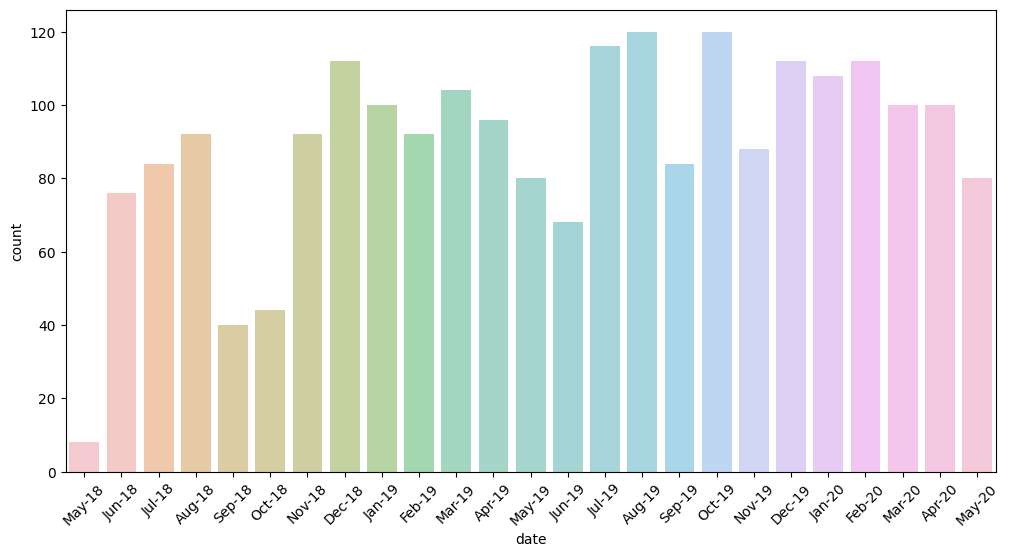

In [21]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

#sns.lineplot(data = df['y_var_1'], marker='o', sort = False, ax=ax1)
#ax2 = ax1.twinx()

sns.barplot(data = datecount, x='date', y='count', alpha=0.5, ax=ax1)
plt.xticks(rotation=45)

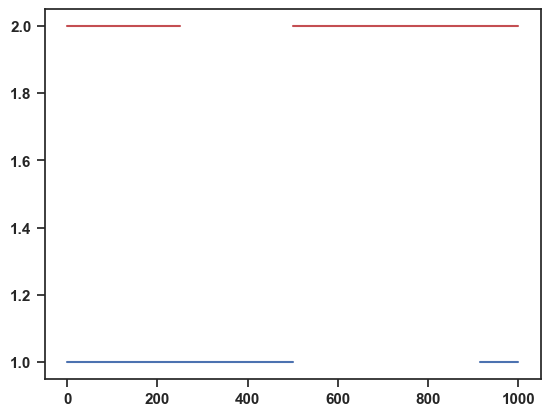

In [42]:
import matplotlib.pyplot as plt

segments = {1: [(0, 500),
                (915, 1000)],
            2: [(0, 250),
                (500, 1000)]}

colors = {1: 'b', 2: 'r'}

for y in segments:
    col = colors.get(y, 'k')
    for seg in segments[y]:
        plt.plot(seg, [y, y], color=col)

### HyperParameter Tuning

In [ ]:
lr = np.array([0.01, 0.0008, 0.001, 0.0009, 0.00001])
lr = np.expand_dims(lr, axis = -1)
dropout = np.array([0.2, 0.2, 0.4, 0.4, 0.6])
dropout = np.expand_dims(dropout, axis = -1)
l2 = np.array([0.01, 0.001, 0.001, 0.001, 0.00001])
l2 = np.expand_dims(l2, axis = -1)

In [ ]:
hyper = numpy.concatenate([lr, dropout,l2], axis = -1)
hyper

In [ ]:
hyper = numpy.concatenate([lr, dropout,l2], axis = -1)
ymins = hyper.min(axis=0)
ymaxs = hyper.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
hypernames = ['Learning Rate', 'Dropout', 'L2 Regularization'] 
target_names = np.array(['6hr lead time', '12hr lead time', '24hr lead time'])
targets = np.array([0, 0, 1, 2, 2])  

# transform all data to be compatible with the main axis
zscnn = np.zeros_like(hyper)
zscnn[:, 0] = hyper[:, 0]
zscnn[:, 1:] = (hyper[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(12,7))

axes = [host] + [host.twinx() for i in range(hyper.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (hyper.shape[1] - 1)))

host.set_xlim(0, hyper.shape[1] - 1)
host.set_xticks(range(hyper.shape[1]))
host.set_xticklabels(hypernames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('FogNet Hyper-Parameters Tuning', fontsize=18, pad=12)

colors = plt.cm.Set2.colors
legend = [None for _ in target_names]


# create bezier curves
v1 = list(zip([x for x in np.linspace(0, len(hyper) - 1, len(hyper) * 3 - 2, endpoint=True)],
                 np.repeat(zscnn[1, :], 3)[1:-1]))
c1 = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(v1) - 1)]
p1 = Path(v1, c1)
pat1 = patches.PathPatch(p1, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[targets[1]])
legend[targets[1]] = pat1
host.add_patch(pat1)


# create bezier curves
v2 = list(zip([x for x in np.linspace(0, len(hyper) - 1, len(hyper) * 3 - 2, endpoint=True)],
                 np.repeat(zscnn[2, :], 3)[1:-1]))
c2 = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(v2) - 1)]
p2 = Path(v2, c2)
pat2 = patches.PathPatch(p2, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[targets[2]])
legend[targets[2]] = pat2
host.add_patch(pat2)


# create bezier curves
v3 = list(zip([x for x in np.linspace(0, len(hyper) - 1, len(hyper) * 3 - 2, endpoint=True)],
                 np.repeat(zscnn[3, :], 3)[1:-1]))
c3 = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(v3) - 1)]
p3 = Path(v3, c3)
pat3 = patches.PathPatch(p3, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[targets[3]])
legend[targets[3]] = pat3
host.add_patch(pat3)


host.legend(legend, target_names,
            loc='lower center', bbox_to_anchor=(0.5, -0.18),
            ncol=len(target_names), fancybox=True, shadow=True)


plt.tight_layout()
plt.show()        
plt.savefig('h.jpg') 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
ynames = iris.feature_names
ys = iris.data
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

ymaxs[1], ymins[1] = ymins[1], ymaxs[1]  # reverse axis 1 to have less crossings
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(10,4))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Parallel Coordinates Plot — Iris', fontsize=18, pad=12)


colors = plt.cm.Set2.colors
legend_handles = [None for _ in iris.target_names]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[iris.target[j]])
    legend_handles[iris.target[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, iris.target_names,
            loc='lower center', bbox_to_anchor=(0.5, -0.18),
            ncol=len(iris.target_names), fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np

n_teams = 4
n_weeks = 4
t = np.array([[1, 2, 4, 3],
              [4, 3, 3, 2],
              [3, 4, 1, 4],
              [2, 1, 2, 1]])


fig, ax = plt.subplots(figsize=(10, 4), facecolor='#1b1b1b')
ax.set_facecolor('#1b1b1b')
indent = 0.8
colors = ['crimson', 'skyblue', 'lime', 'gold']


for tj, color in zip(t, colors):
    ax.scatter(np.arange(len(tj)), tj, marker='o', color=color, s=100, zorder=3)
    verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor=color)
    ax.add_patch(patch)
    
    
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[iris.target[j]])
    legend_handles[iris.target[j]] = patch
    host.add_patch(patch)